In [9]:
import re
# import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import shutil
import numpy as np
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple

In [81]:
def plot_err(x_input, results, labels, xylabels, title=None, path=None, plottype=None):
    with PdfPages(f'{path}/{title.replace(" ", "_")}.pdf') as pdf:
        patch = []
        for i, (xaxis, result, label) in enumerate(zip(x_input, results, labels)):
            if plottype=='semilogx':
                plt.semilogx(xaxis, result, label=label, color=f'C{i}')
            elif plottype=='semilogy': 
                plt.semilogy(xaxis, result, label=label, color=f'C{i}')
            elif plottype=='loglog': 
                plt.loglog(xaxis, result, label=label, color=f'C{i}')
            else:
                if i==0:
                    p = plt.scatter(xaxis, result, label=label, s=100, color=f'C{i}', marker=r'$\clubsuit$')
                elif i>0:
                    index = np.argsort(xaxis).astype(int)
                    xaxis = [ xaxis[i] for i in index ]
                    result = [ result[i] for i in index ]
                    # print(f'index={index}')
                    p = plt.plot(xaxis, result, label=label, color=f'C{i}', marker='.', markersize=12)
                else:
                    p = plt.plot(xaxis, result, label=label, color=f'C{i}', marker='.', markersize=12)
                patch.append(p)
        # if title:
        #     plt.title(title)
        plt.xticks(fontsize=15, rotation=30)
        plt.yticks(fontsize=15)
        plt.xlabel(xylabels[0], fontsize=15)
        plt.ylabel(xylabels[1], fontsize=15) ## Pokec-n
        # l1 = plt.legend([patch[0], patch[1], patch[2]], [labels[0], labels[1], labels[2]], prop={'size': 18}, loc="upper center")
        # plt.gca().add_artist(l1)
        # plt.legend([patch[3], patch[4]], [labels[3], labels[4]], prop={'size': 18}, loc="lower right")
        
        plt.legend(bbox_to_anchor=(-0.1, 1.02, 1.1, .102), ncol=5, prop={'size': 12}, mode="expand", loc='lower right')
        plt.grid()
        if path:
            pdf.savefig()
        plt.show()

In [11]:
def extract_perf(file_path):
    file_target = open(file_path, 'r')
    for i, line in enumerate(file_target):
        ls = line.strip('\n')
        if "Test statistics" in ls:
            if "acc" in ls:
                acc = re.findall(r"acc:(.*?)[,$]", ls)[0]
                acc = np.float_(acc.split('+-'))
                perf = acc
            elif "D_SP" in ls:
                D_SP = re.findall(r"D_SP:(.*)", ls)[0]
                D_SP = np.float_(D_SP.split('+-'))
                fair = D_SP
    return perf, fair

In [170]:
file_path = f'./log/pokec_z/kernel/GAT/hyper=0.0-4.log'
perf, fair = extract_perf(file_path)
perf 

array([0.8817, 0.0049])

In [65]:
def extract_curve(file_path):
    file_target = open(file_path, 'r')
    perfs, fairs = np.empty([0]), np.empty([0])
    for i, line in enumerate(file_target):
        ls = line.strip('\n')
        if "- test acc:" in ls:
            break
        if "test acc" in ls:
            acc = re.findall(r"test acc:(.*)", ls)
            acc = np.float_(acc)
            perf = acc
            perfs = np.concatenate((perfs, perf))
        if "test D_SP" in ls:
            # D_SP = np.float_(re.findall(r"DP test:(.*)", ls)[0])
            D_SP = re.findall(r"test D_SP:(.*)", ls)
            fair = np.float_(D_SP)
            fairs = np.concatenate((fairs, fair))
    return perfs, fairs

def curve_methods(dataset, methods, model, hypers_all, running_times = 5):
    perfs_mean_all, perfs_std_all, fairs_mean_all, fairs_std_all = [], [], [], []
    for index in range(len(hypers_all)):
        hypers = hypers_all[index]
        perfs_mean, perfs_std, fairs_mean, fairs_std = [], [], [], []
        for i, method in enumerate(methods):
            path_root = f'./log/{dataset}/{method}/{model}/hyper={hypers[i]}-'
            perfs, fairs = [], []
            for running_time in range(running_times):
                file_path = path_root + f'{running_time}.log'
                perf, fair = extract_curve(file_path)
                perfs.append(perf)
                fairs.append(fair)
            perfs = np.array(perfs)
            fairs = np.array(fairs)
            perfs_mean.append(list(perfs.mean(axis=0)* 100))
            perfs_std.append(list(perfs.std(axis=0) * 100))
            fairs_mean.append(list(fairs.mean(axis=0) * 100))
            fairs_std.append(list(fairs.std(axis=0) * 100))
        perfs_mean_all.append(perfs_mean)
        perfs_std_all.append(perfs_std)
        fairs_mean_all.append(fairs_mean)
        fairs_std_all.append(fairs_std)


    results = {"perf_mean":perfs_mean_all,
            "perf_std":perfs_std_all,
            "fair_mean":fairs_mean_all,
            "fair_std":fairs_std_all}
    return results

def plot_figure(results, methods, hypers_all, dataset, model): 
    # plt.figure(figsize=(12.4, 12.0))  
    # f, ax = plt.subplots(1,len(hypers_all))
    # plt.subplots_adjust(wspace=0.7)
    # ax2 = [ax[i].twinx() for i in range(len(ax))]
    colors = ['r', 'b', 'm', 'c']  #cm.viridis(0.1, 0.3, 0.6, 0.9)
    for index in range(len(hypers_all)):
      # plt.subplot(1,len(hypers_all),index+1)
      plt.figure()
      f, ax = plt.subplots(1, 1)
      ax2 = ax.twinx()
      hypers = hypers_all[index]
      patch1, patch2 = [], []
      for i in range(len(colors)):
        perf_mean = results['perf_mean'][index][i]
        perf_std = results['perf_std'][index][i]
        fair_mean = results['fair_mean'][index][i]
        fair_std = results['fair_std'][index][i]

        p1, = ax.plot(np.arange(len(perf_mean))/len(perf_mean)*100, perf_mean, color=colors[i], label=f'{methods[i]}-{hypers[i]}')
        r1 = list(map(lambda x: x[0]-x[1], zip(perf_mean, perf_std)))
        r2 = list(map(lambda x: x[0]+x[1], zip(perf_mean, perf_std)))
        ax.fill_between(np.arange(len(perf_mean))/len(perf_mean)*100, r1, r2, facecolor=colors[i], alpha=0.1)

        p2, = ax2.plot(np.arange(len(fair_mean))/len(perf_mean)*100, fair_mean, color=colors[i], linestyle='dotted')
        r1 = list(map(lambda x: x[0]-x[1], zip(fair_mean, fair_std)))
        r2 = list(map(lambda x: x[0]+x[1], zip(fair_mean, fair_std)))
        ax2.fill_between(np.arange(len(fair_mean))/len(perf_mean)*100, r1, r2, facecolor=colors[i], alpha=0.1)
        patch1.append(p1)
        patch2.append(p2)

      ax.legend([(patch1[i], patch2[i]) for i in range(len(methods))], [f'{methods[i]}-{hypers[i]}' for i in range(len(methods))], \
                  numpoints=1, handler_map={tuple: HandlerTuple(ndivide=None)}, \
                  bbox_to_anchor=(-0.0, 1.02, 1.2, .102), ncol=4, mode="expand", loc='lower right')

      ax2.invert_yaxis() ### invert y_2
      ax.set_xlabel('Training progress')
      ax.set_ylabel(r"$\bf{Accuracy}$" + '(solid)')
      ax2.set_ylabel(r"$\bf{GDP}$" + '(dotted)')
      exp_dir = 'results/'
      plt.savefig(exp_dir + f'{dataset}_' + f'{model}_curve_{index}' + '.pdf', dpi=50)
      plt.show()

<Figure size 432x288 with 0 Axes>

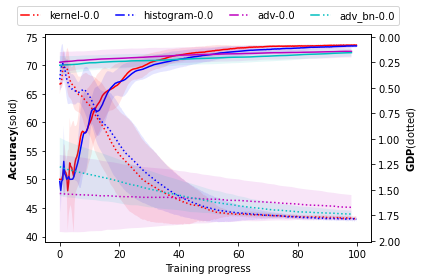

<Figure size 432x288 with 0 Axes>

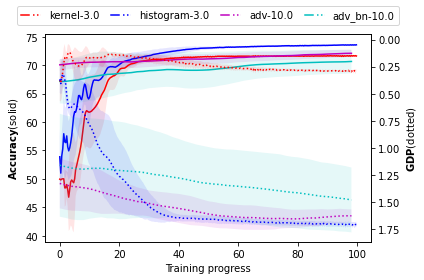

<Figure size 432x288 with 0 Axes>

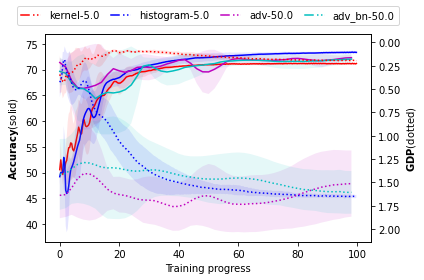

<Figure size 432x288 with 0 Axes>

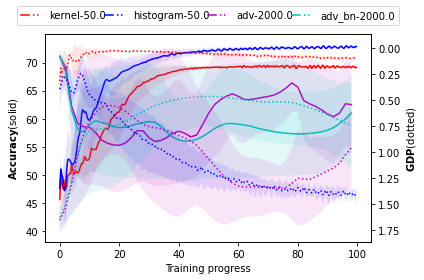

<Figure size 432x288 with 0 Axes>

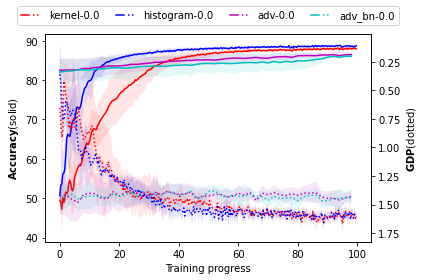

<Figure size 432x288 with 0 Axes>

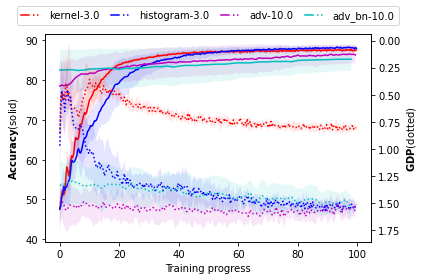

<Figure size 432x288 with 0 Axes>

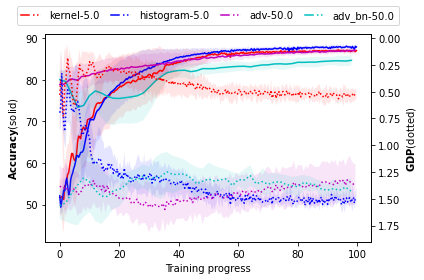

<Figure size 432x288 with 0 Axes>

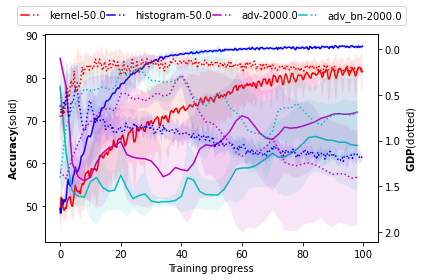

<Figure size 432x288 with 0 Axes>

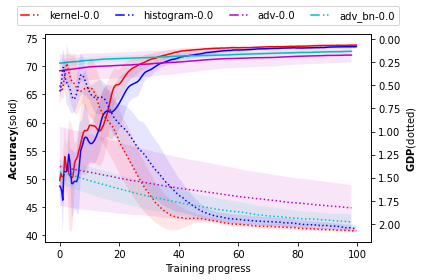

<Figure size 432x288 with 0 Axes>

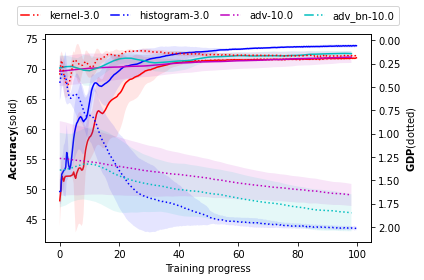

<Figure size 432x288 with 0 Axes>

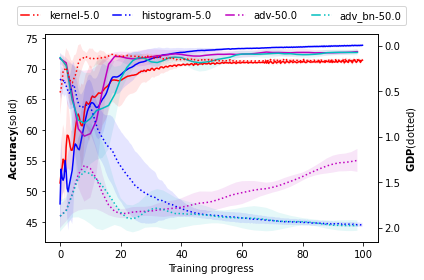

<Figure size 432x288 with 0 Axes>

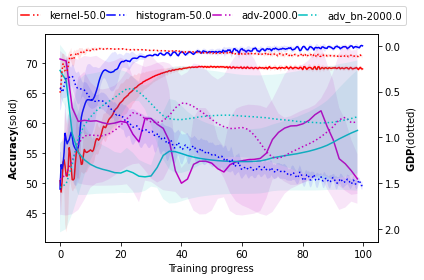

<Figure size 432x288 with 0 Axes>

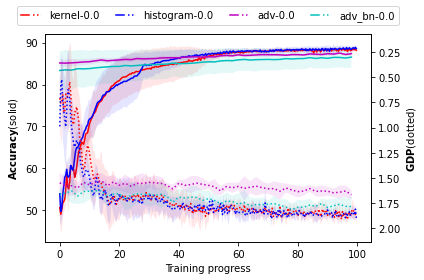

<Figure size 432x288 with 0 Axes>

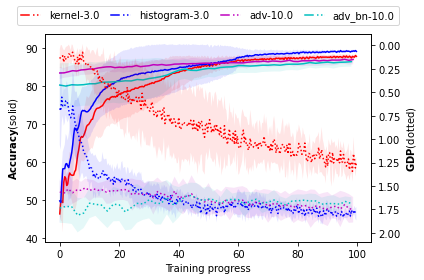

<Figure size 432x288 with 0 Axes>

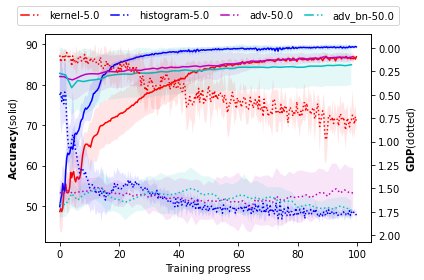

<Figure size 432x288 with 0 Axes>

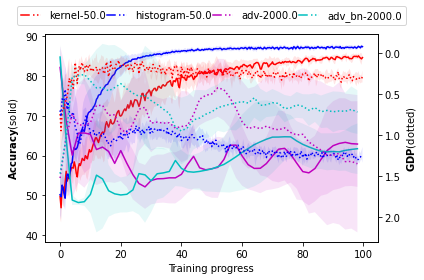

In [37]:
datasets = ['pokec_n', 'pokec_z'] ### pokec_z pokec_n
methods = ['kernel', 'kernel_bn', 'adv', 'adv_bn'] 
methods2 = ['kernel', 'histogram', 'adv', 'adv_bn'] 
models = ['GCN', 'GAT']  ### GAT GCN SGC
hypers = [[0.0, 0.0, 0.0, 0.0],
        [3.0, 3.0, 10.0, 10.0],
        [5.0, 5.0, 50.0, 50.0],
        [50.0, 50.0, 2000.0, 2000.0]]
for dataset in datasets:
    for model in models:
        results = curve_methods(dataset, methods, model, hypers)
        plot_figure(results, methods2, hypers,dataset, model)

<Figure size 432x288 with 0 Axes>

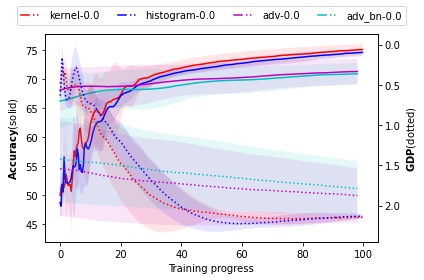

<Figure size 432x288 with 0 Axes>

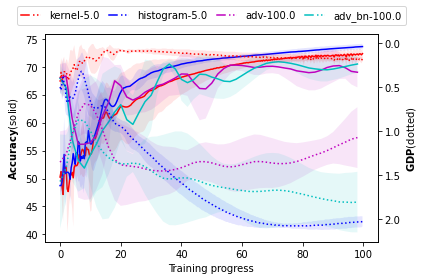

<Figure size 432x288 with 0 Axes>

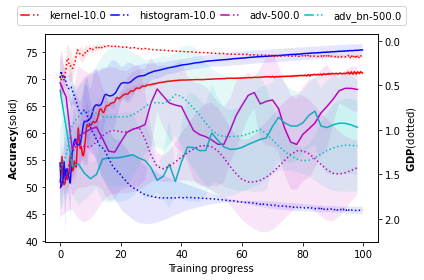

<Figure size 432x288 with 0 Axes>

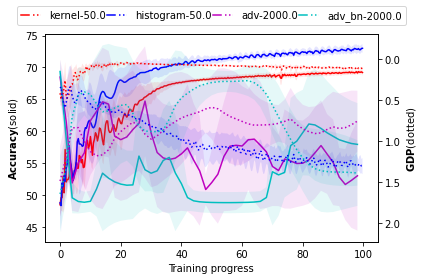

<Figure size 432x288 with 0 Axes>

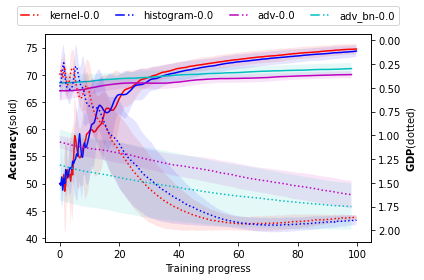

<Figure size 432x288 with 0 Axes>

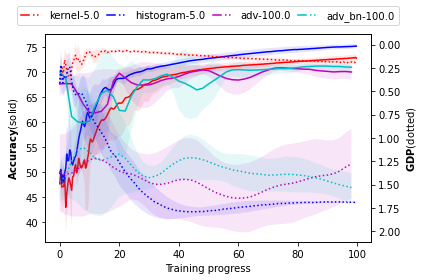

<Figure size 432x288 with 0 Axes>

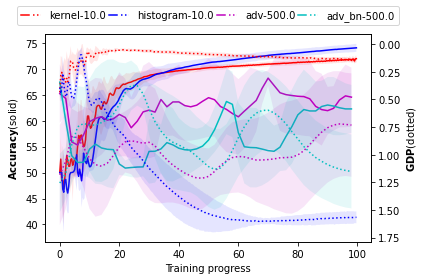

<Figure size 432x288 with 0 Axes>

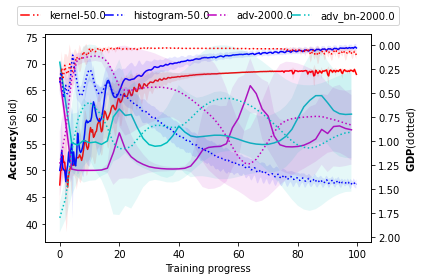

In [38]:
datasets = ['pokec_z', 'pokec_n'] ### pokec_z pokec_n
methods = ['kernel', 'kernel_bn', 'adv', 'adv_bn'] 
methods2 = ['kernel', 'histogram', 'adv', 'adv_bn'] 
model = 'SGC'  ### GAT GCN SGC
hypers = [[0.0, 0.0, 0.0, 0.0],
        [5.0, 5.0, 100.0, 100.0],
        [10.0, 10.0, 500.0, 500.0],
        [50.0, 50.0, 2000.0, 2000.0]]
for dataset in datasets:
        results = curve_methods(dataset, methods, model, hypers)
        plot_figure(results, methods2, hypers,dataset, model)

In [88]:
dataset = 'pokec_z'
method = 'kernel'
model = 'GAT'
hyper = 0.0
running_times = 5
path_root = f'./log/{dataset}/{method}/{model}/hyper={hyper}-'
perfs, fairs = [], []
for running_time in range(running_times):
    file_path = path_root + f'{running_time}.log'
    perf, fair = extract_curve(file_path)
    perfs.append(perf)
    fairs.append(fair)
perfs = np.array(perfs)
fairs = np.array(fairs)
results = {"perf_mean":perfs.mean(axis=0),
            "perf_std":perfs.std(axis=0),
            "fair_mean":fairs.mean(axis=0),
            "fair_std":fairs.std(axis=0)}
results

{'perf_mean': array([0.50562, 0.48968, 0.50104, 0.5169 , 0.5203 , 0.52602, 0.54754,
        0.58684, 0.55424, 0.55008, 0.56644, 0.60334, 0.60368, 0.59676,
        0.59732, 0.578  , 0.58704, 0.60222, 0.6207 , 0.63956, 0.64394,
        0.65482, 0.6622 , 0.65928, 0.65728, 0.66622, 0.68058, 0.6833 ,
        0.68442, 0.69574, 0.70638, 0.7125 , 0.71872, 0.72316, 0.72914,
        0.73212, 0.73534, 0.74264, 0.74852, 0.75336, 0.75822, 0.75904,
        0.76092, 0.7653 , 0.77056, 0.77198, 0.7748 , 0.78032, 0.7832 ,
        0.78394, 0.78762, 0.7918 , 0.79532, 0.797  , 0.79782, 0.80148,
        0.8036 , 0.80496, 0.80708, 0.80838, 0.80914, 0.81186, 0.81458,
        0.81678, 0.81776, 0.81818, 0.81838, 0.8184 , 0.82094, 0.82232,
        0.82414, 0.82554, 0.82488, 0.82808, 0.82744, 0.82784, 0.82952,
        0.83148, 0.8306 , 0.83062, 0.83136, 0.83244, 0.8359 , 0.83408,
        0.83582, 0.83524, 0.83642, 0.8369 , 0.83824, 0.83778, 0.8381 ,
        0.83884, 0.83664, 0.84132, 0.84092, 0.8404 , 0.84278, 0.

In [16]:
def results_extract(method, dataset, model, alpha_vec=None, running_times=5):
    perfs, fairs = np.empty([0,2]), np.empty([0, 2])

    methods = ["kernel", "kernel_bn", "adv", "adv_bn"]
    
    if method in methods:
        index = methods.index(method)
        alphas = alpha_vec[index]
        for alpha in alphas:
            file_path = f'./log/{dataset}/{method}/{model}/hyper={alpha}-{running_times-1}.log'
            
            perf, fair = extract_perf(file_path)
            
            perfs = np.concatenate((perfs, np.expand_dims(perf, 0)))
            fairs = np.concatenate((fairs, np.expand_dims(fair, 0)))

    return perfs, fairs

In [23]:
def results_all(methods, dataset, model, alpha_vec=None, running_times=5):
    perfs, fairs = [], []
    for method in methods:
        perf, fair = results_extract(method, dataset, model, alpha_vec, running_times)
        perf, fair = list(perf[:,0]*100), list(fair[:,0]*100)
        if method=="kernel":
            perfs.append(perf[0:1])
            fairs.append(fair[0:1])
        perfs.append(perf[1:])
        fairs.append(fair[1:])
    ### return len(methods) + 1
    return perfs, fairs

In [29]:
def plot_tradeoff(method_vec, dataset, model, alpha_vec):
    perfs, fairs = results_all(method_vec, dataset, model, alpha_vec)

    xaxis = fairs
    results = perfs
    labels = ['vanilla', 'kernel', 'histogram', 'adv', 'adv_bn']
    xylabels = ['GDP', 'Acc']
    title = f'{dataset}_{model}_tradeoff'
    path = 'results'

    plot_err(xaxis, results, labels, xylabels, title, path)

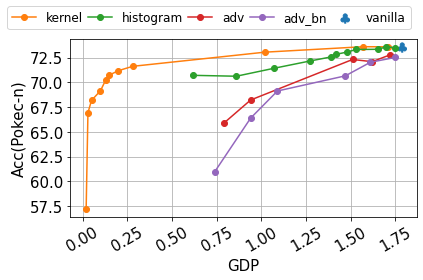

In [61]:
dataset = 'pokec_n'  ## 'pokec_n' 'pokec_z'
model = 'GCN' ## 'GAT', 'GCN'
method_vec = ['kernel', 'kernel_bn', 'adv', 'adv_bn']   ## 'kernel', 'kernel_bn', 'adv', 'adv_bn'
alpha_vec = [[0.0, 0.1, 0.3, 1.0, 3.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0, 500.0],
            [0.0, 1.0, 3.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0, 500.0, 1000.0, 2000.0],
            [0.0, 1.0, 10.0, 50.0, 500.0, 1000.0],
            [0.0, 1.0, 10.0, 50.0, 500.0, 1000.0, 2000.0]]
## kernel = [0.0, 1.0, 3.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0, 500.0]
## adv = [0.0, 1.0, 10.0, 50.0, 100.0, 500.0, 1000.0, 2000.0]

plot_tradeoff(method_vec, dataset, model, alpha_vec)

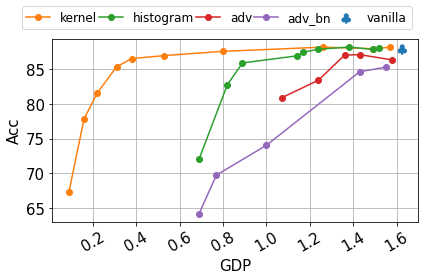

In [82]:
dataset = 'pokec_n'  ## 'pokec_n' 'pokec_z'
model = 'GAT' ## 'GAT', 'GCN'
method_vec = ['kernel', 'kernel_bn', 'adv', 'adv_bn']   ## 'kernel', 'kernel_bn', 'adv', 'adv_bn'
alpha_vec = [[0.0, 0.1, 0.3, 1.0, 3.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0],
            [0.0, 3.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0, 500.0, 2000.0],
            [0.0, 10.0, 50.0, 100.0, 300.0, 1000.0],
            [0.0, 10.0, 50.0, 500.0, 1000.0, 2000.0]]
## kernel = [0.0, 1.0, 3.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0, 500.0]
## adv = [0.0, 1.0, 10.0, 50.0, 100.0, 500.0, 1000.0, 2000.0]

plot_tradeoff(method_vec, dataset, model, alpha_vec)

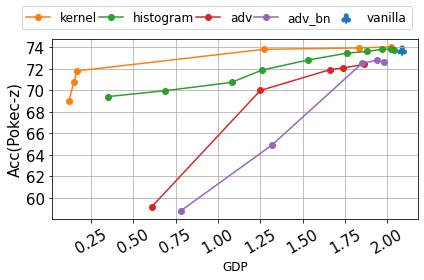

In [80]:
dataset = 'pokec_z'  ## 'pokec_n' 'pokec_z'
model = 'GCN' ## 'GAT', 'GCN'
method_vec = ['kernel', 'kernel_bn', 'adv', 'adv_bn']   ## 'kernel', 'kernel_bn', 'adv', 'adv_bn'
alpha_vec = [[0.0, 0.1, 0.3, 1.0, 3.0, 10.0, 50.0],
            [0.0, 1.0, 3.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0, 500.0, 2000.0],
            [0.0, 1.0, 10.0, 100.0, 500.0, 1000.0],
            [0.0, 1.0, 10.0, 50.0, 500.0, 2000.0]]
## kernel = [0.0, 1.0, 3.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0, 500.0]
## adv = [0.0, 1.0, 10.0, 50.0, 100.0, 500.0, 1000.0, 2000.0]

plot_tradeoff(method_vec, dataset, model, alpha_vec)

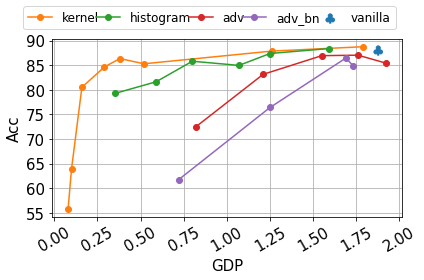

In [83]:
dataset = 'pokec_z'  ## 'pokec_n' 'pokec_z'
model = 'GAT' ## 'GAT', 'GCN', 'SGC'
method_vec = ['kernel', 'kernel_bn', 'adv', 'adv_bn']   ## 'kernel', 'kernel_bn', 'adv', 'adv_bn'
alpha_vec = [[0.0, 1.0, 3.0, 10.0, 20.0, 50.0, 100.0, 200.0, 500.0],
            [0.0, 20.0, 50.0, 100.0, 200.0, 500.0, 1000.0],
            [0.0, 10.0, 50.0, 100.0, 500.0, 1500.0],
            [0.0, 10.0, 50.0, 500.0, 2000.0]]
## kernel = [0.0, 1.0, 3.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0, 500.0]
## adv = [0.0, 1.0, 10.0, 50.0, 100.0, 500.0, 1000.0, 2000.0]

plot_tradeoff(method_vec, dataset, model, alpha_vec)

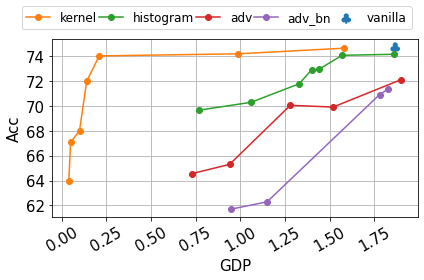

In [84]:
dataset = 'pokec_n'  ## 'pokec_n' 'pokec_z'
model = 'SGC' ## 'GAT', 'GCN'
method_vec = ['kernel', 'kernel_bn', 'adv', 'adv_bn']   ## 'kernel', 'kernel_bn', 'adv', 'adv_bn'
alpha_vec = [[0.0, 0.3, 1.0, 3.0, 10.0, 50.0, 100.0, 200.0],
            [0.0, 1.0, 10.0, 50.0, 100.0, 200.0, 500.0, 1000.0],
            [0.0, 1.0, 50.0, 100.0, 500.0, 1000.0],
            [0.0, 10.0, 50.0, 500.0, 1000.0]]
## kernel = [0.0, 1.0, 3.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0, 500.0]
## adv = [0.0, 1.0, 10.0, 50.0, 100.0, 500.0, 1000.0, 2000.0]

plot_tradeoff(method_vec, dataset, model, alpha_vec)

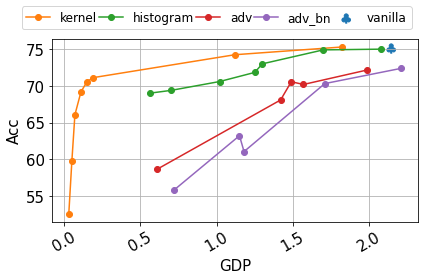

In [85]:
dataset = 'pokec_z'  ## 'pokec_n' 'pokec_z'
model = 'SGC' ## 'GAT', 'GCN'
method_vec = ['kernel', 'kernel_bn', 'adv', 'adv_bn']   ## 'kernel', 'kernel_bn', 'adv', 'adv_bn'
alpha_vec = [[0.0, 0.3, 1.0, 10.0, 20.0, 50.0, 100.0, 200.0, 500.0],
            [0.0, 1.0, 20.0, 50.0, 100.0, 200.0, 500.0, 1000.0],
            [0.0, 3.0, 10.0, 50.0, 500.0, 1000.0],
            [0.0, 10.0, 50.0, 500.0, 1500.0, 1000.0]]
## kernel = [0.0, 1.0, 3.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0, 500.0]
## adv = [0.0, 1.0, 10.0, 50.0, 100.0, 500.0, 1000.0, 2000.0]

plot_tradeoff(method_vec, dataset, model, alpha_vec)

In [ ]:
# perfs, fairs = results_all(method_vec, dataset, model, alpha_vec)

# xaxis = fairs
# results = perfs
# labels = ['vanilla', 'kernel', 'kernel_bn', 'adv', 'adv_bn']
# xylabels = ['DP', 'Acc']
# title = f'{dataset}_{model}_tradeoff'
# path = 'results'

# plot_err(xaxis, results, labels, xylabels, title, path)